# Trigonometric Mods

In [1]:
'''
Dependency injection, some functional programming principles, and a modified version of the pattern made popular in Redux.
'''
'''
Import widgets directly
Set initial values based upon state
'''

from enum import Enum
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets as widgets

In [2]:
out = widgets.Output()

theta = np.linspace(-np.pi, 4 * np.pi, 1000)

class Prop(Enum):
    TRIG_FUNCTION = 'trig-function'
    PHASE_SHIFT = 'phase-shift'
    VERTICAL_SHIFT = 'vertical-shift'
    HORIZONTAL_SCALAR = 'horizontal-scalar'
    VERTICAL_SCALAR = 'vertical-scalar'


In [3]:
class Dispatcher:
    _actions = {}

    def add_action(self, prop):
        def fn(action):
            if not prop in self._actions:
                self._actions[prop] = []
            self._actions[prop].append(action)
            return self
        return fn

    def on(self, prop):
        def fn(data):
            self.dispatch(prop, data)
            return data
        return fn

    def dispatch(self, prop, data):
        for action in self._actions[prop]:
            action(data, prop)
        return self


class StateDispatcher(Dispatcher):
    _state = {}

    def __init__(self, state):
        self._state.update(state)

    def on(self, prop):
        def fn(data):
            self._state.update({prop: data})
            state = self._state.copy()
            self.dispatch(prop, state)
            return state
        return fn

dispatcher = StateDispatcher({
    Prop.PHASE_SHIFT: 0,
    Prop.VERTICAL_SHIFT: 0,
    Prop.HORIZONTAL_SCALAR: 0,
    Prop.VERTICAL_SCALAR: 0,
})

def calculate_trig_function_value(x, vertical_scalar = 1, horizontal_scalar = 1, phase_shift = 0, vertical_shift = 0):
    return vertical_scalar * np.sin(horizontal_scalar * (x - phase_shift)) + vertical_shift

# Mutates the label widget.
def update_label(label):
    def fn(data, prop):
        value = data[prop]
        label.value = f"{value:.1f}"
        return {prop: value}
    return fn

# Mutates the wave plot.
def update_wave_plot(_plot):
    def fn(theta):
        def gn(data, _prop=None):
            with out:
                out.clear_output()
                plt.ioff()

                phase_shift = data[Prop.PHASE_SHIFT]
                vertical_shift = data[Prop.VERTICAL_SHIFT]
                horizontal_scalar = data[Prop.HORIZONTAL_SCALAR]
                vertical_scalar = data[Prop.VERTICAL_SCALAR]

                y_unscaled = [calculate_trig_function_value(i) for i in theta]
                y_scaled = [calculate_trig_function_value(i, vertical_scalar, horizontal_scalar, phase_shift, vertical_shift) for i in theta]
                
                fig, ax = plt.subplots()
                ax.plot(theta, y_unscaled, 'k--')
                display(fig)
                # plt.clf()
                # plt.plot(theta, y_unscaled, 'k--')
                # plt.plot(theta, y_scaled, 'b')
                # plt.show()
        return gn
    return fn

def update_wave_plot2(change):
    with out:
        out.clear_output()
        plt.ioff()

        phase_shift = dispatcher._state[Prop.PHASE_SHIFT]
        vertical_shift = dispatcher._state[Prop.VERTICAL_SHIFT]
        horizontal_scalar = dispatcher._state[Prop.HORIZONTAL_SCALAR]
        vertical_scalar = dispatcher._state[Prop.VERTICAL_SCALAR]

        y_unscaled = [calculate_trig_function_value(i) for i in theta]
        y_scaled = [calculate_trig_function_value(i, vertical_scalar, horizontal_scalar, phase_shift, vertical_shift) for i in theta]
        
        fig, ax = plt.subplots()
        ax.plot(theta, y_unscaled, 'k--')
        display(fig)
                # plt.clf()
                # plt.plot(theta, y_unscaled, 'k--')
                # plt.plot(theta, y_scaled, 'b')
                # plt.show()


In [4]:
def on_change(dispatcher):
    def fn(prop):
        def gn(event):
            value = event['new']
            dispatcher.on(prop)(value)
            return value
        return gn
    return fn

# change to options
def define_slider(dispatcher, prop, description, value=0, min=-5, max=5):
    label = widgets.Label(description)
    label.layout.width = '8rem'
    label_value = widgets.Label(f"{value:.1f}")
    label_value.layout.width = '3rem'
    label_value.layout.margin = '2px 0 0 1rem'
    label_value.layout.justify_content = 'flex-end'
    label_min = widgets.Label(f"{min:.1f}")
    label_min.style.text_color = 'gray'
    label_max = widgets.Label(f"{max:.1f}")
    label_max.style.text_color = 'gray'
    slider = widgets.FloatSlider(
        value=0,
        min=-5,
        max=5,
        step=0.1,
        orientation='horizontal',
        readout=False
    )

    # When we get a dispatch that the value associated with this slider has changed,
    # update the label.
    dispatcher.add_action(prop)(update_label(label_value))
    slider.observe(on_change(dispatcher)(prop), names="value")
    slider.observe(update_wave_plot2, names="value")

    slider_container = widgets.HBox([label_min, slider, label_max])
    slider_container.layout.justify_content = 'center'
    container = widgets.HBox([label, slider_container, label_value])
    container.layout.justify_content = 'space-between'

    return container


def define_ui_layout(dispatcher):
    children = [
        define_slider(dispatcher, Prop.PHASE_SHIFT, 'Phase Shift'),
        define_slider(dispatcher, Prop.VERTICAL_SHIFT, 'Vertical Shift'),
        define_slider(dispatcher, Prop.HORIZONTAL_SCALAR, 'Horizontal Scalar'),
        define_slider(dispatcher, Prop.VERTICAL_SCALAR, 'Vertical Scalar'),
    ]

    bottom_column = widgets.VBox(children=children)
    bottom_column.layout = widgets.Layout(
        padding='0.5rem',
        border='1px solid lightgray',
        width='fit-content'
    )

    toggle_buttons = widgets.ToggleButtons(options=["Sine", "Cosine"])
    toggle_buttons_layout = widgets.Layout(margin='0 0 1rem 0')
    toggle_buttons_container = widgets.Box(children=[toggle_buttons], layout=toggle_buttons_layout)

    layout = widgets.Layout(
        display='flex',
        flex_flow='column',
        align_items='stretch')
    main_container = widgets.Box(children=[toggle_buttons_container, bottom_column], layout=layout)

    return main_container


Box(children=(Box(children=(ToggleButtons(options=('Sine', 'Cosine'), value='Sine'),), layout=Layout(margin='0…

Output()

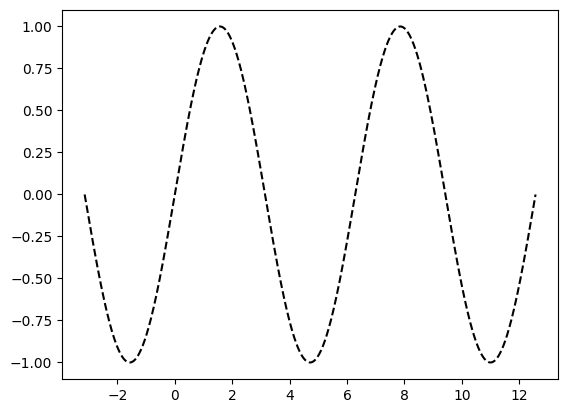

In [5]:
# dispatcher = StateDispatcher({
#     Prop.PHASE_SHIFT: 0,
#     Prop.VERTICAL_SHIFT: 0,
#     Prop.HORIZONTAL_SCALAR: 0,
#     Prop.VERTICAL_SCALAR: 0,
# })

# theta = np.linspace(-np.pi, 4 * np.pi, 1000)
# dispatcher.add_action(Prop.PHASE_SHIFT)(update_wave_plot(None)(theta))
# dispatcher.add_action(Prop.VERTICAL_SHIFT)(update_wave_plot(plt)(theta))
# dispatcher.add_action(Prop.HORIZONTAL_SCALAR)(update_wave_plot(plt)(theta))
# dispatcher.add_action(Prop.VERTICAL_SCALAR)(update_wave_plot(plt)(theta))


ui = define_ui_layout(dispatcher)
# ui = define_ui_layout(update_state(dispatcher))
# print(dispatcher._actions)

display(ui)
display(out)

In [6]:
# plt.show()